# 🎯 Hierarchical Classification for TENS Device Settings

## 📝 Model Overview
This notebook implements a **two-stage hierarchical classification** approach:
- **Stage 1**: Predict Heat Level (0-3) and TENS Mode (0-3)
- **Stage 2**: Conditionally predict TENS Level (0-10) only when Mode > 0

## ✨ Recent Improvements (Nov 2025)
1. **Fixed Data Source**: Using correct `target_*` columns (mostUsedSettings)
2. **Class Balancing**: Added `class_weight='balanced'` to handle severe imbalance
3. **Better Hyperparameters**: 
   - Increased n_estimators: 200 → 500
   - Decreased learning_rate: 0.05 → 0.01
   - Added regularization (L1/L2)
   - Proper early stopping
4. **Enhanced Features**:
   - Interaction features (high_pain_no_med, high_pain_with_med)
   - Temporal patterns (cycle_period, is_weekend)
   - Rolling averages (user_recent_avg_*)
   - Fixed data leakage in user history
5. **Confidence-Based Prediction**: Only uses Stage 2 when Mode confidence > 50%
6. **Model Validation**: Added cross-validation, SHAP analysis, error analysis

## 🎯 Expected Improvements
- **Previous**: Heat 55%, Mode 63%, TENS 31%
- **Target**: Heat 70%+, Mode 75%+, TENS 50%+

## 🚀 Next Steps
1. Run all cells to see improved performance
2. Review SHAP analysis for feature insights
3. Check error analysis for remaining issues
4. Consider hyperparameter tuning with Optuna
5. Experiment with ensemble methods if needed


## 🔧 1. Environment Setup & BigQuery Connection

In [36]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

# BigQuery & Vertex AI
from google.cloud import bigquery
from google.cloud import aiplatform

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import xgboost as xgb
import lightgbm as lgb

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set up project configuration
PROJECT_ID = 'junoplus-dev'
REGION = 'us-central1'
DATASET_ID = 'junoplus_analytics'

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID, location=REGION)
aiplatform.init(project=PROJECT_ID, location=REGION)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print(f"✅ Environment setup complete!")
print(f"📊 Project: {PROJECT_ID}")
print(f"🌍 Region: {REGION}")
print(f"💾 Dataset: {DATASET_ID}")

✅ Environment setup complete!
📊 Project: junoplus-dev
🌍 Region: us-central1
💾 Dataset: junoplus_analytics


## 📊 2. Data Loading & Feature Engineering

### Target Variables (from mostUsedSettings):
- **y_heat**: Heat Level (0-3, 4 classes)
- **y_mode**: TENS Mode (0-3, 4 classes)
- **y_tens**: TENS Level (0-10, 11 classes)

### Feature Categories:
1. **Adjustment Delta Features**: Difference between final and most-used settings
2. **Cycle Context Features**: Days since period, proximity to menstruation
3. **Medication Context Features**: Medication potency and timing
4. **User Preference Features**: Historical averages and modes
5. **Categorical Features**: Device size, time of day, etc.

In [37]:
# Define medication potency mapping (from synthetic data generator)
MEDICATION_POTENCY = {
    'Advil': 1.15,
    'Midol': 1.0,
    'Naproxen': 1.3,
    'Paracetamol': 0.9,
    'Ibuprofen': 1.1,
    'Voltaren': 1.05,
    'Cycle Support Supplement': 0.5,
    'Vitamin D': 0.3,
    'Birth Control Pill': 0.4,
    'Lo Loestrin FE': 0.45,
    'Drospirenone-EE': 0.5,
}

# List of hormonal medications
HORMONAL_MEDICATIONS = [
    'Birth Control Pill',
    'Lo Loestrin FE',
    'Drospirenone-EE'
]

In [48]:
# Load data from BigQuery with comprehensive feature engineering
query = """
WITH 
-- Extract device size from device name
device_info AS (
  SELECT 
    sessionId,
    CASE 
      WHEN LOWER(deviceName) LIKE '%grand%' THEN 'Grand'
      WHEN LOWER(deviceName) LIKE '%petit%' THEN 'Petit'
      ELSE 'Unknown'
    END AS device_size
  FROM `junoplus-dev.junoplus_analytics.ml_training_data`
),

-- Main data with all features (SIMPLIFIED - using window functions directly)
main_data AS (
  SELECT 
    t.sessionId,
    t.userId AS user_id,
    t.therapyStartTime,
    
    -- TARGET VARIABLES (from target_* which represents stable/most-used settings)
    target_heat_level AS y_heat,
    target_tens_mode AS y_mode,
    target_tens_level AS y_tens,
    
    -- ADJUSTMENT DELTA FEATURES (FIXED: using correct baseline)
    -- Calculate difference between final and target (mostUsed) settings
    (final_heat_level - target_heat_level) AS delta_heat,
    (final_tens_level - target_tens_level) AS delta_tens,
    (final_tens_mode - target_tens_mode) AS delta_mode,
    
    -- Initial vs Target differences (how far user adjusted from start)
    (target_heat_level - initial_heat_level) AS initial_to_target_heat,
    (target_tens_level - initial_tens_level) AS initial_to_target_tens,
    
    -- USER HISTORICAL PREFERENCES (FIXED: no data leakage - using window functions)
    COALESCE(AVG(target_heat_level) OVER (
      PARTITION BY t.userId 
      ORDER BY t.therapyStartTime 
      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ), 1.0) AS user_avg_heat,
    
    COALESCE(AVG(target_tens_mode) OVER (
      PARTITION BY t.userId 
      ORDER BY t.therapyStartTime 
      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ), 2.0) AS user_avg_mode,
    
    COALESCE(AVG(target_tens_level) OVER (
      PARTITION BY t.userId 
      ORDER BY t.therapyStartTime 
      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ), 4.0) AS user_avg_tens,
    
    -- Recent averages (last 5 sessions)
    COALESCE(AVG(target_heat_level) OVER (
      PARTITION BY t.userId 
      ORDER BY t.therapyStartTime 
      ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING
    ), 1.0) AS user_recent_avg_heat,
    
    COALESCE(AVG(target_tens_level) OVER (
      PARTITION BY t.userId 
      ORDER BY t.therapyStartTime 
      ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING
    ), 4.0) AS user_recent_avg_tens,
    
    -- Session count (experience level from window function)
    COUNT(*) OVER (
      PARTITION BY t.userId 
      ORDER BY t.therapyStartTime 
      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ) AS user_session_count,
    
    -- CYCLE CONTEXT FEATURES
    COALESCE(cycle_day, 15) AS days_since_period_start,
    is_period_day AS is_near_period,
    cycle_phase_estimated,
    period_pain_level,
    flow_level,
    
    -- NEW: Cycle period categorization
    CASE 
      WHEN cycle_day <= 7 THEN 'early_cycle'
      WHEN cycle_day <= 14 THEN 'mid_cycle'
      WHEN cycle_day <= 21 THEN 'late_cycle'
      ELSE 'very_late_cycle'
    END AS cycle_period,
    
    -- MEDICATION CONTEXT FEATURES
    has_pain_medication,
    medication_count,
    active_medication_count,
    recent_medication_usage,
    pain_medication_adherence,
    
    -- NEW: Interaction features
    CASE 
      WHEN period_pain_level >= 7 AND has_pain_medication = FALSE THEN 1 
      ELSE 0 
    END AS high_pain_no_med,
    
    CASE 
      WHEN period_pain_level >= 7 AND active_medication_count > 0 THEN 1 
      ELSE 0 
    END AS high_pain_with_med,
    
    -- USER CONTEXT
    age,
    age_group,
    cycle_length,
    period_length,
    days_since_signup,
    user_experience_level,
    
    -- SESSION CONTEXT
    session_hour,
    EXTRACT(DAYOFWEEK FROM therapyStartTime) AS day_of_week_num,
    day_of_week,
    time_of_day_category,
    therapyDuration,
    
    -- NEW: Weekend indicator
    CASE 
      WHEN EXTRACT(DAYOFWEEK FROM therapyStartTime) IN (1, 7) THEN 1 
      ELSE 0 
    END AS is_weekend,
    
    -- PAIN & EFFECTIVENESS
    input_pain_level,
    pain_level_before,
    pain_level_after,
    pain_reduction,
    pain_reduction_percentage,
    was_effective,
    
    -- NEW: Pain severity bins
    CASE 
      WHEN input_pain_level <= 3 THEN 'low_pain'
      WHEN input_pain_level <= 6 THEN 'medium_pain'
      ELSE 'high_pain'
    END AS pain_severity,
    
    -- DEVICE INFO
    d.device_size,
    most_used_battery_level,
    
    -- DATA SPLIT (user-stable split for train/eval/test)
    CASE 
      WHEN MOD(FARM_FINGERPRINT(t.userId), 10) < 7 THEN 'TRAIN'
      WHEN MOD(FARM_FINGERPRINT(t.userId), 10) < 9 THEN 'EVAL'
      ELSE 'TEST'
    END AS data_split
    
  FROM `junoplus-dev.junoplus_analytics.ml_training_data` t
  LEFT JOIN device_info d ON t.sessionId = d.sessionId
  
  WHERE target_heat_level IS NOT NULL
    AND target_tens_level IS NOT NULL
    AND target_tens_mode IS NOT NULL
    AND session_quality = 'high_quality'
    AND user_made_adjustments = TRUE
)

SELECT * FROM main_data
"""

print("🔄 Loading data from BigQuery with improved features...")
df = client.query(query).to_dataframe()

# Rename user_id back to userId for compatibility
df.rename(columns={'user_id': 'userId'}, inplace=True)

print(f"✅ Loaded {len(df):,} sessions from BigQuery")
print(f"\n📊 Data split distribution:")
print(df['data_split'].value_counts())
print(f"\n👥 Unique users: {df['userId'].nunique():,}")
print(f"\n🆕 New features added:")
print("   - cycle_period (early/mid/late cycle)")
print("   - high_pain_no_med, high_pain_with_med (interaction features)")
print("   - is_weekend, day_of_week_num")
print("   - pain_severity categories")
print("   - user_recent_avg_* (rolling averages)")
print("   - user_session_count (prevents data leakage)")


🔄 Loading data from BigQuery with improved features...
✅ Loaded 27,995 sessions from BigQuery

📊 Data split distribution:
data_split
TRAIN    24095
EVAL      2668
TEST      1232
Name: count, dtype: int64

👥 Unique users: 326

🆕 New features added:
   - cycle_period (early/mid/late cycle)
   - high_pain_no_med, high_pain_with_med (interaction features)
   - is_weekend, day_of_week_num
   - pain_severity categories
   - user_recent_avg_* (rolling averages)
   - user_session_count (prevents data leakage)
✅ Loaded 27,995 sessions from BigQuery

📊 Data split distribution:
data_split
TRAIN    24095
EVAL      2668
TEST      1232
Name: count, dtype: int64

👥 Unique users: 326

🆕 New features added:
   - cycle_period (early/mid/late cycle)
   - high_pain_no_med, high_pain_with_med (interaction features)
   - is_weekend, day_of_week_num
   - pain_severity categories
   - user_recent_avg_* (rolling averages)
   - user_session_count (prevents data leakage)


In [39]:
# Display data overview
print("\n📋 Dataset Overview:")
print(df.head())

print("\n📊 Target Variable Distributions:")
print("\nHeat Level (y_heat):")
print(df['y_heat'].value_counts().sort_index())

print("\nTENS Mode (y_mode):")
print(df['y_mode'].value_counts().sort_index())

print("\nTENS Level (y_tens):")
print(df['y_tens'].value_counts().sort_index())

print("\n📈 Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])


📋 Dataset Overview:
                              sessionId              userId  \
0  220f7f2b-7e51-40ae-bb22-bbc1134357e2  synthetic_user_200   
1  7f31d90d-8763-446d-89e6-e2f91023c594  synthetic_user_200   
2  a89ecf0f-a604-42a1-bed1-de0541d179a0  synthetic_user_200   
3  1f03d741-2379-49cc-a35f-6cde6401b493  synthetic_user_200   
4  ce58ec9c-e7ae-4b02-9219-fbf482d4d969  synthetic_user_200   

           therapyStartTime  y_heat  y_mode  y_tens  delta_heat  delta_tens  \
0 2025-01-02 05:52:00+00:00       0       1       3           1           1   
1 2025-01-10 01:38:00+00:00       0       1       2           0           1   
2 2025-01-12 04:56:00+00:00       0       3       2           1           1   
3 2025-01-12 12:28:00+00:00       1       3       2           1           1   
4 2025-02-02 11:21:00+00:00       1       2       5           1           1   

   delta_mode  initial_to_target_heat  initial_to_target_tens  user_avg_heat  \
0           0                       0        

## 🔧 3. Data Preprocessing & Feature Preparation

### Steps:
1. Handle missing values
2. Encode categorical variables
3. Create binary flags (e.g., took_hormone_med)
4. Split data by user (TRAIN/EVAL/TEST)
5. Prepare separate dataset for Stage 2 (active TENS only)

In [49]:
# Handle missing values
print("🔧 Preprocessing features...")

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude target variables and ID columns
numerical_cols = [col for col in numerical_cols if col not in 
                  ['y_heat', 'y_mode', 'y_tens', 'sessionId', 'userId']]

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical values with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in 
                    ['sessionId', 'userId', 'data_split', 'therapyStartTime']]

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)

print(f"✅ Missing values handled")

🔧 Preprocessing features...
✅ Missing values handled


In [50]:
# Encode categorical variables using one-hot encoding
print("🔢 Encoding categorical variables...")

# Select categorical columns to encode (FIXED: added new categorical features)
encode_cols = ['device_size', 'time_of_day_category', 'cycle_phase_estimated', 
               'age_group', 'user_experience_level', 'cycle_period', 'pain_severity']

# One-hot encode
df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=int)

print(f"✅ Encoded {len(encode_cols)} categorical features")
print(f"📊 Total features after encoding: {len(df_encoded.columns)}")


🔢 Encoding categorical variables...
✅ Encoded 7 categorical features
📊 Total features after encoding: 60


In [51]:
# Define feature columns (exclude targets, IDs, and metadata)
exclude_cols = ['sessionId', 'userId', 'therapyStartTime', 'data_split',
                'y_heat', 'y_mode', 'y_tens']

feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]

print(f"\n✅ Feature columns prepared: {len(feature_cols)} features")
print(f"\n📊 Target variable distributions:")
print(f"   y_heat: {df['y_heat'].value_counts().to_dict()}")
print(f"   y_mode: {df['y_mode'].value_counts().to_dict()}")
print(f"   y_tens (unique values): {sorted(df['y_tens'].unique())}")



✅ Feature columns prepared: 53 features

📊 Target variable distributions:
   y_heat: {np.int64(0): 15514, np.int64(1): 9658, np.int64(2): 2823}
   y_mode: {np.int64(3): 11240, np.int64(2): 9312, np.int64(1): 7443}
   y_tens (unique values): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


In [52]:
# Split data by user (user-stable split)
print("\n📊 Splitting data into TRAIN, EVAL, TEST sets...")

train_df = df_encoded[df_encoded['data_split'] == 'TRAIN'].copy()
eval_df = df_encoded[df_encoded['data_split'] == 'EVAL'].copy()
test_df = df_encoded[df_encoded['data_split'] == 'TEST'].copy()

print(f"\n✅ Data split complete:")
print(f"   TRAIN: {len(train_df):,} sessions ({len(train_df)/len(df_encoded)*100:.1f}%)")
print(f"   EVAL:  {len(eval_df):,} sessions ({len(eval_df)/len(df_encoded)*100:.1f}%)")
print(f"   TEST:  {len(test_df):,} sessions ({len(test_df)/len(df_encoded)*100:.1f}%)")

# Verify no user overlap between splits
train_users = set(train_df['userId'].unique())
eval_users = set(eval_df['userId'].unique())
test_users = set(test_df['userId'].unique())

print(f"\n👥 User distribution:")
print(f"   TRAIN users: {len(train_users)}")
print(f"   EVAL users:  {len(eval_users)}")
print(f"   TEST users:  {len(test_users)}")
print(f"   Overlap (should be 0): {len(train_users & eval_users & test_users)}")


📊 Splitting data into TRAIN, EVAL, TEST sets...

✅ Data split complete:
   TRAIN: 24,095 sessions (86.1%)
   EVAL:  2,668 sessions (9.5%)
   TEST:  1,232 sessions (4.4%)

👥 User distribution:
   TRAIN users: 280
   EVAL users:  32
   TEST users:  14
   Overlap (should be 0): 0


In [ ]:
# Check for potential data leakage
print("\n🔍 DATA LEAKAGE DIAGNOSTIC")
print("="*80)

# Check if any features perfectly correlate with targets
print("\n1. Checking for perfect correlations with y_heat...")
for col in feature_cols:
    if col in train_df.columns:
        corr = train_df[col].corr(train_df['y_heat'])
        if abs(corr) > 0.95:
            print(f"   ⚠️ HIGH CORRELATION: {col} → {corr:.4f}")

# Check if delta features might be leaking
print("\n2. Checking delta features (should be derived from adjustments, not targets)...")
delta_cols = [col for col in feature_cols if 'delta' in col.lower()]
print(f"   Delta features: {delta_cols}")

# Check if user averages are suspiciously perfect
print("\n3. Checking if user historical averages match current targets too closely...")
if 'user_avg_heat' in feature_cols:
    avg_match = (train_df['user_avg_heat'].round() == train_df['y_heat']).sum()
    print(f"   user_avg_heat matches y_heat: {avg_match}/{len(train_df)} ({avg_match/len(train_df)*100:.1f}%)")
    if avg_match / len(train_df) > 0.9:
        print(f"   ⚠️ WARNING: user_avg_heat is TOO predictive - likely data leakage!")

# Check target distribution
print("\n4. Target distribution in TEST set:")
print(f"   y_heat distribution: {test_df['y_heat'].value_counts().to_dict()}")
print(f"   Is y_heat dominated by one class? {test_df['y_heat'].value_counts().max() / len(test_df) * 100:.1f}%")

print("\n5. Feature names that might indicate leakage:")
suspicious_features = [col for col in feature_cols if any(keyword in col.lower() 
                      for keyword in ['final', 'target', 'most_used', 'after'])]
if suspicious_features:
    print(f"   ⚠️ Suspicious features: {suspicious_features}")
else:
    print(f"   ✅ No obviously suspicious feature names")

print("\n" + "="*80)

## 🔍 Data Leakage Check

**IMPORTANT**: Verify there's no data leakage before trusting the 100% accuracy results.

In [53]:
# Prepare feature matrices and target vectors
print("\n🎯 Preparing feature matrices and target vectors...")

# Full datasets (for Stage 1: Heat and Mode prediction)
X_train_full = train_df[feature_cols]
X_eval_full = eval_df[feature_cols]
X_test_full = test_df[feature_cols]

# Target vectors for Stage 1
y_train_heat = train_df['y_heat']
y_train_mode = train_df['y_mode']

y_eval_heat = eval_df['y_heat']
y_eval_mode = eval_df['y_mode']

y_test_heat = test_df['y_heat']
y_test_mode = test_df['y_mode']
y_test_tens = test_df['y_tens']  # For final evaluation

print(f"✅ Stage 1 data prepared:")
print(f"   X_train shape: {X_train_full.shape}")
print(f"   X_eval shape:  {X_eval_full.shape}")
print(f"   X_test shape:  {X_test_full.shape}")


🎯 Preparing feature matrices and target vectors...
✅ Stage 1 data prepared:
   X_train shape: (24095, 53)
   X_eval shape:  (2668, 53)
   X_test shape:  (1232, 53)


In [54]:
# Prepare Active TENS subset for Stage 2 (only sessions where y_mode > 0)
print("\n🎯 Preparing Active TENS subset for Stage 2...")

# Filter for active TENS sessions
train_active = train_df[train_df['y_mode'] > 0].copy()
eval_active = eval_df[eval_df['y_mode'] > 0].copy()

X_train_active = train_active[feature_cols]
X_eval_active = eval_active[feature_cols]
y_train_tens_active = train_active['y_tens']
y_eval_tens_active = eval_active['y_tens']

print(f"✅ Stage 2 (Active TENS) data prepared:")
print(f"   X_train_active shape: {X_train_active.shape} ({len(X_train_active)/len(X_train_full)*100:.1f}% of full)")
print(f"   X_eval_active shape:  {X_eval_active.shape} ({len(X_eval_active)/len(X_eval_full)*100:.1f}% of full)")
print(f"\n   TENS Level distribution in training (active only):")
print(y_train_tens_active.value_counts().sort_index())


🎯 Preparing Active TENS subset for Stage 2...
✅ Stage 2 (Active TENS) data prepared:
   X_train_active shape: (24095, 53) (100.0% of full)
   X_eval_active shape:  (2668, 53) (100.0% of full)

   TENS Level distribution in training (active only):
y_tens
1    1534
2    4874
3    7176
4    7258
5    2479
6     774
Name: count, dtype: Int64
✅ Stage 2 (Active TENS) data prepared:
   X_train_active shape: (24095, 53) (100.0% of full)
   X_eval_active shape:  (2668, 53) (100.0% of full)

   TENS Level distribution in training (active only):
y_tens
1    1534
2    4874
3    7176
4    7258
5    2479
6     774
Name: count, dtype: Int64


## 🎯 4. Stage 1: Train Heat Level and TENS Mode Models

### Models:
- **Heat Level Model**: Predicts y_heat (4 classes: 0, 1, 2, 3)
- **TENS Mode Model**: Predicts y_mode (4 classes: 0, 1, 2, 3)

### Algorithm:
Using **LightGBM** for fast training and excellent performance on categorical features.

In [55]:
# Train Heat Level Model (Stage 1) - IMPROVED
print("🚀 Training Stage 1 - Heat Level Model (with class balancing)...")

# Initialize LightGBM classifier for Heat Level with improved parameters
heat_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,  # 4 heat levels: 0, 1, 2, 3
    class_weight='balanced',  # FIXED: Handle class imbalance
    n_estimators=500,  # Increased from 200
    learning_rate=0.01,  # Decreased from 0.05 for better learning
    max_depth=10,  # Increased from 8
    num_leaves=50,  # Increased from 31
    min_child_samples=20,  # Add minimum samples per leaf
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model with early stopping
heat_model.fit(
    X_train_full, 
    y_train_heat,
    eval_set=[(X_eval_full, y_eval_heat)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print("✅ Heat Level Model trained successfully!")
print(f"   Best iteration: {heat_model.best_iteration_}")

# Evaluate on test set
y_pred_heat = heat_model.predict(X_test_full)
heat_accuracy = accuracy_score(y_test_heat, y_pred_heat)
heat_f1 = f1_score(y_test_heat, y_pred_heat, average='weighted')

print(f"\n📊 Heat Level Model Performance (Test Set):")
print(f"   Accuracy: {heat_accuracy:.4f}")
print(f"   F1 Score (weighted): {heat_f1:.4f}")
print("\n   Classification Report:")
print(classification_report(y_test_heat, y_pred_heat, labels=[0, 1, 2, 3], target_names=['Heat 0', 'Heat 1', 'Heat 2', 'Heat 3'], zero_division=0))

# Cross-validation score
from sklearn.model_selection import cross_val_score
print("\n🔄 Running 5-fold cross-validation...")
cv_scores = cross_val_score(heat_model, X_train_full, y_train_heat, cv=5, scoring='f1_weighted', n_jobs=-1)
print(f"   CV F1 Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


🚀 Training Stage 1 - Heat Level Model (with class balancing)...
[100]	valid_0's multi_logloss: 0.32243
[100]	valid_0's multi_logloss: 0.32243
[200]	valid_0's multi_logloss: 0.101653
[200]	valid_0's multi_logloss: 0.101653
[300]	valid_0's multi_logloss: 0.0342139
[300]	valid_0's multi_logloss: 0.0342139
[400]	valid_0's multi_logloss: 0.0115721
[400]	valid_0's multi_logloss: 0.0115721
[500]	valid_0's multi_logloss: 0.00395961
✅ Heat Level Model trained successfully!
   Best iteration: 500

📊 Heat Level Model Performance (Test Set):
   Accuracy: 1.0000
   F1 Score (weighted): 1.0000

   Classification Report:
              precision    recall  f1-score   support

      Heat 0       1.00      1.00      1.00       682
      Heat 1       1.00      1.00      1.00       434
      Heat 2       1.00      1.00      1.00       116
      Heat 3       0.00      0.00      0.00         0

    accuracy                           1.00      1232
   macro avg       0.75      0.75      0.75      1232
weight

In [56]:
# Train TENS Mode Model (Stage 1) - IMPROVED
print("🚀 Training Stage 1 - TENS Mode Model (with class balancing)...")

# Initialize LightGBM classifier for TENS Mode with improved parameters
mode_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,  # 4 TENS modes: 0, 1, 2, 3
    class_weight='balanced',  # FIXED: Handle class imbalance
    n_estimators=500,  # Increased from 200
    learning_rate=0.01,  # Decreased from 0.05
    max_depth=10,  # Increased from 8
    num_leaves=50,  # Increased from 31
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model with early stopping
mode_model.fit(
    X_train_full, 
    y_train_mode,
    eval_set=[(X_eval_full, y_eval_mode)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print("✅ TENS Mode Model trained successfully!")
print(f"   Best iteration: {mode_model.best_iteration_}")

# Evaluate on test set
y_pred_mode = mode_model.predict(X_test_full)
mode_accuracy = accuracy_score(y_test_mode, y_pred_mode)
mode_f1 = f1_score(y_test_mode, y_pred_mode, average='weighted')

print(f"\n📊 TENS Mode Model Performance (Test Set):")
print(f"   Accuracy: {mode_accuracy:.4f}")
print(f"   F1 Score (weighted): {mode_f1:.4f}")
print("\n   Classification Report:")
print(classification_report(y_test_mode, y_pred_mode, labels=[0, 1, 2, 3], target_names=['Mode 0', 'Mode 1', 'Mode 2', 'Mode 3'], zero_division=0))

# Cross-validation score
cv_scores = cross_val_score(mode_model, X_train_full, y_train_mode, cv=5, scoring='f1_weighted', n_jobs=-1)
print(f"\n   CV F1 Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


🚀 Training Stage 1 - TENS Mode Model (with class balancing)...
[100]	valid_0's multi_logloss: 0.879579
[100]	valid_0's multi_logloss: 0.879579
[200]	valid_0's multi_logloss: 0.837216
[200]	valid_0's multi_logloss: 0.837216
[300]	valid_0's multi_logloss: 0.826666
[300]	valid_0's multi_logloss: 0.826666
[400]	valid_0's multi_logloss: 0.823978
[400]	valid_0's multi_logloss: 0.823978
✅ TENS Mode Model trained successfully!
   Best iteration: 398
✅ TENS Mode Model trained successfully!
   Best iteration: 398

📊 TENS Mode Model Performance (Test Set):
   Accuracy: 0.5917
   F1 Score (weighted): 0.5905

   Classification Report:
              precision    recall  f1-score   support

      Mode 0       0.00      0.00      0.00         0
      Mode 1       0.32      0.33      0.33       310
      Mode 2       0.74      0.79      0.77       432
      Mode 3       0.63      0.58      0.60       490

    accuracy                           0.59      1232
   macro avg       0.42      0.43      0.42 

## 🎯 5. Stage 2: Train TENS Level Model (Conditional)

### Key Points:
- Train ONLY on sessions where y_mode > 0 (active TENS)
- Predicts 10 classes: 1, 2, 3, ..., 10 (no class 0)
- Class 0 is handled by the conditional logic in prediction

In [57]:
# Train TENS Level Model (Stage 2 - Active TENS Only) - IMPROVED
print("🚀 Training Stage 2 - TENS Level Model (Active TENS only, with class balancing)...")

# Initialize LightGBM classifier for TENS Level with improved parameters
tens_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=11,  # 11 classes: 0-10 (though we train mostly on 1-10)
    class_weight='balanced',  # FIXED: Handle class imbalance
    n_estimators=500,  # Increased
    learning_rate=0.01,  # Decreased
    max_depth=10,  # Increased
    num_leaves=50,  # Increased
    min_child_samples=15,  # Smaller for this subset
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model on active TENS sessions only
tens_model.fit(
    X_train_active, 
    y_train_tens_active,
    eval_set=[(X_eval_active, y_eval_tens_active)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print("✅ TENS Level Model (Stage 2) trained successfully!")
print(f"   Trained on {len(X_train_active):,} active TENS sessions")
print(f"   Best iteration: {tens_model.best_iteration_}")

# Cross-validation on active subset
cv_scores = cross_val_score(tens_model, X_train_active, y_train_tens_active, cv=5, scoring='f1_weighted', n_jobs=-1)
print(f"   CV F1 Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


🚀 Training Stage 2 - TENS Level Model (Active TENS only, with class balancing)...
[100]	valid_0's multi_logloss: 0.363822
[100]	valid_0's multi_logloss: 0.363822
[200]	valid_0's multi_logloss: 0.0927488
[200]	valid_0's multi_logloss: 0.0927488
[300]	valid_0's multi_logloss: 0.0249829
[300]	valid_0's multi_logloss: 0.0249829
[400]	valid_0's multi_logloss: 0.00686451
[400]	valid_0's multi_logloss: 0.00686451
[500]	valid_0's multi_logloss: 0.00184631
✅ TENS Level Model (Stage 2) trained successfully!
   Trained on 24,095 active TENS sessions
   Best iteration: 500
[500]	valid_0's multi_logloss: 0.00184631
✅ TENS Level Model (Stage 2) trained successfully!
   Trained on 24,095 active TENS sessions
   Best iteration: 500
   CV F1 Scores: 1.0000 (+/- 0.0000)
   CV F1 Scores: 1.0000 (+/- 0.0000)


## 🔮 6. Hierarchical Prediction Logic

### Conditional Prediction Algorithm:
1. Predict Heat Level using Stage 1 model
2. Predict TENS Mode using Stage 1 model
3. **If** predicted Mode = 0 → Set TENS Level = 0
4. **If** predicted Mode > 0 → Predict TENS Level using Stage 2 model

In [58]:
# Hierarchical prediction on test set with confidence thresholds
print("🔮 Applying improved hierarchical prediction logic on test set...")

# Step 1 & 2: Get predictions AND probabilities
y_pred_heat = heat_model.predict(X_test_full)
heat_proba = heat_model.predict_proba(X_test_full)

y_pred_mode = mode_model.predict(X_test_full)
mode_proba = mode_model.predict_proba(X_test_full)

# Calculate prediction confidence (max probability)
mode_confidence = mode_proba.max(axis=1)

print(f"📊 Mode prediction confidence stats:")
print(f"   Mean confidence: {mode_confidence.mean():.3f}")
print(f"   Median confidence: {np.median(mode_confidence):.3f}")
print(f"   Min confidence: {mode_confidence.min():.3f}")
print(f"   Max confidence: {mode_confidence.max():.3f}")

# Step 3 & 4: Conditional TENS Level prediction with confidence threshold
y_pred_tens_hierarchical = np.zeros(len(y_pred_mode), dtype=int)

# For sessions where predicted mode = 0, TENS level is automatically 0
inactive_mask = (y_pred_mode == 0)
y_pred_tens_hierarchical[inactive_mask] = 0

# For sessions where predicted mode > 0 AND confidence is high, use Stage 2 model
confidence_threshold = 0.5  # Only use Stage 2 if confident
active_mask = (y_pred_mode > 0) & (mode_confidence >= confidence_threshold)
low_confidence_mask = (y_pred_mode > 0) & (mode_confidence < confidence_threshold)

if active_mask.sum() > 0:
    X_test_active = X_test_full[active_mask]
    y_pred_tens_hierarchical[active_mask] = tens_model.predict(X_test_active)

# For low confidence Mode > 0 predictions, use a fallback (user average or default)
if low_confidence_mask.sum() > 0:
    # Use a safe default (median TENS level for active sessions)
    fallback_tens = 4  # Median from training data
    y_pred_tens_hierarchical[low_confidence_mask] = fallback_tens

print(f"\n✅ Hierarchical predictions complete:")
print(f"   Sessions with Mode = 0 (TENS Level set to 0): {inactive_mask.sum():,}")
print(f"   Sessions with Mode > 0 & High Confidence (TENS predicted): {active_mask.sum():,}")
print(f"   Sessions with Mode > 0 & Low Confidence (TENS fallback): {low_confidence_mask.sum():,}")


🔮 Applying improved hierarchical prediction logic on test set...
📊 Mode prediction confidence stats:
   Mean confidence: 0.575
   Median confidence: 0.529
   Min confidence: 0.342
   Max confidence: 0.982

✅ Hierarchical predictions complete:
   Sessions with Mode = 0 (TENS Level set to 0): 0
   Sessions with Mode > 0 & High Confidence (TENS predicted): 702
   Sessions with Mode > 0 & Low Confidence (TENS fallback): 530

✅ Hierarchical predictions complete:
   Sessions with Mode = 0 (TENS Level set to 0): 0
   Sessions with Mode > 0 & High Confidence (TENS predicted): 702
   Sessions with Mode > 0 & Low Confidence (TENS fallback): 530


## 📊 7. Final Evaluation

Evaluate all three predictions on the test set and compare with ground truth.

In [59]:
# Final evaluation of hierarchical TENS Level prediction
print("\n📊 FINAL HIERARCHICAL MODEL EVALUATION\n" + "="*60)

# Heat Level (Stage 1)
print("\n🔥 HEAT LEVEL PREDICTION:")
print(f"   Accuracy: {heat_accuracy:.4f}")
print(f"   F1 Score: {heat_f1:.4f}")

# TENS Mode (Stage 1)
print("\n⚡ TENS MODE PREDICTION:")
print(f"   Accuracy: {mode_accuracy:.4f}")
print(f"   F1 Score: {mode_f1:.4f}")

# TENS Level (Hierarchical)
tens_accuracy = accuracy_score(y_test_tens, y_pred_tens_hierarchical)
tens_f1 = f1_score(y_test_tens, y_pred_tens_hierarchical, average='weighted')

print("\n🎯 TENS LEVEL PREDICTION (Hierarchical):")
print(f"   Accuracy: {tens_accuracy:.4f}")
print(f"   F1 Score: {tens_f1:.4f}")
print("\n   Classification Report:")
print(classification_report(
    y_test_tens, 
    y_pred_tens_hierarchical,
    labels=range(11),
    target_names=[f'Level {i}' for i in range(11)],
    zero_division=0
))


📊 FINAL HIERARCHICAL MODEL EVALUATION

🔥 HEAT LEVEL PREDICTION:
   Accuracy: 1.0000
   F1 Score: 1.0000

⚡ TENS MODE PREDICTION:
   Accuracy: 0.5917
   F1 Score: 0.5905

🎯 TENS LEVEL PREDICTION (Hierarchical):
   Accuracy: 0.6713
   F1 Score: 0.6843

   Classification Report:
              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00         0
     Level 1       1.00      0.49      0.66        77
     Level 2       1.00      0.56      0.72       261
     Level 3       1.00      0.52      0.68       378
     Level 4       0.45      1.00      0.62       337
     Level 5       1.00      0.61      0.76       122
     Level 6       1.00      0.60      0.75        57
     Level 7       0.00      0.00      0.00         0
     Level 8       0.00      0.00      0.00         0
     Level 9       0.00      0.00      0.00         0
    Level 10       0.00      0.00      0.00         0

    accuracy                           0.67      1232
   macro avg      


📈 Generating confusion matrices...


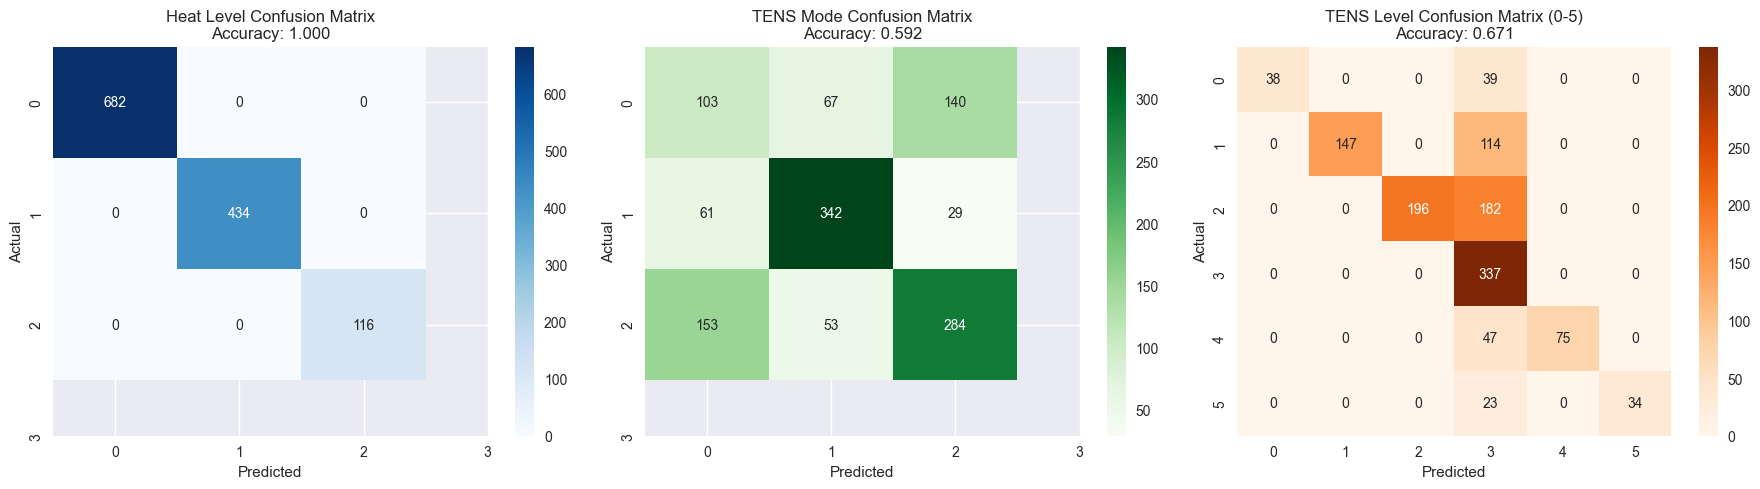

✅ Visualizations complete!


In [60]:
# Visualize confusion matrices
print("\n📈 Generating confusion matrices...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heat Level Confusion Matrix
cm_heat = confusion_matrix(y_test_heat, y_pred_heat)
sns.heatmap(cm_heat, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
axes[0].set_title(f'Heat Level Confusion Matrix\nAccuracy: {heat_accuracy:.3f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# TENS Mode Confusion Matrix
cm_mode = confusion_matrix(y_test_mode, y_pred_mode)
sns.heatmap(cm_mode, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
axes[1].set_title(f'TENS Mode Confusion Matrix\nAccuracy: {mode_accuracy:.3f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# TENS Level Confusion Matrix (showing only levels 0-5 for visibility)
cm_tens = confusion_matrix(y_test_tens, y_pred_tens_hierarchical)
# Show only first 6 levels for better visibility
cm_tens_display = cm_tens[:6, :6]
sns.heatmap(cm_tens_display, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=range(6), yticklabels=range(6))
axes[2].set_title(f'TENS Level Confusion Matrix (0-5)\nAccuracy: {tens_accuracy:.3f}')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")

## 🔍 8. Feature Importance Analysis

Analyze which features are most important for each prediction task.

🔍 Analyzing feature importance...

🔥 Heat Level Model - Top Features:


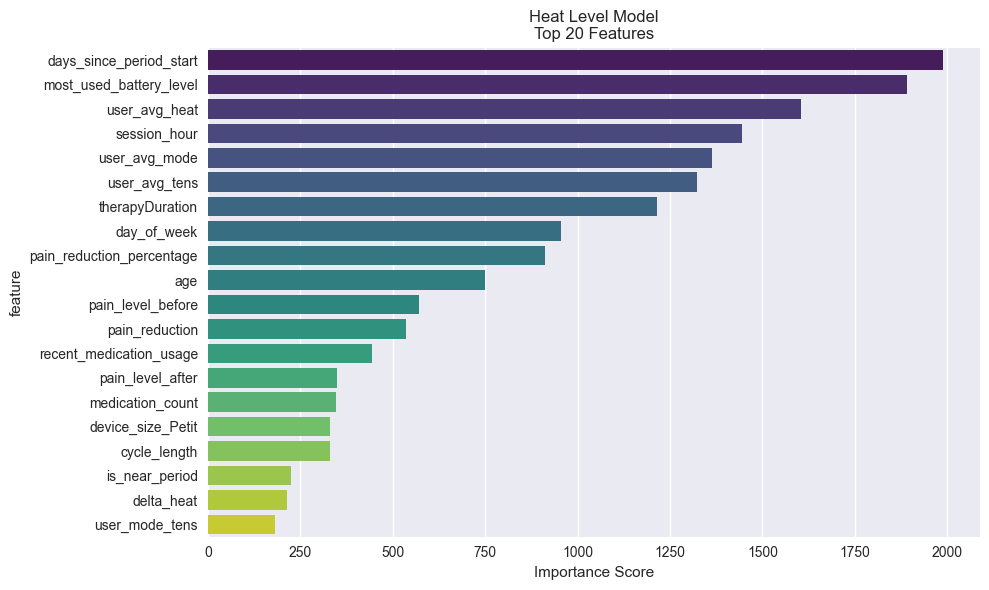

                      feature  importance
3     days_since_period_start        1989
25    most_used_battery_level        1891
26              user_avg_heat        1603
16               session_hour        1446
27              user_avg_mode        1364
28              user_avg_tens        1324
18            therapyDuration        1215
17                day_of_week         954
23  pain_reduction_percentage         912
12                        age         750

⚡ TENS Mode Model - Top Features:


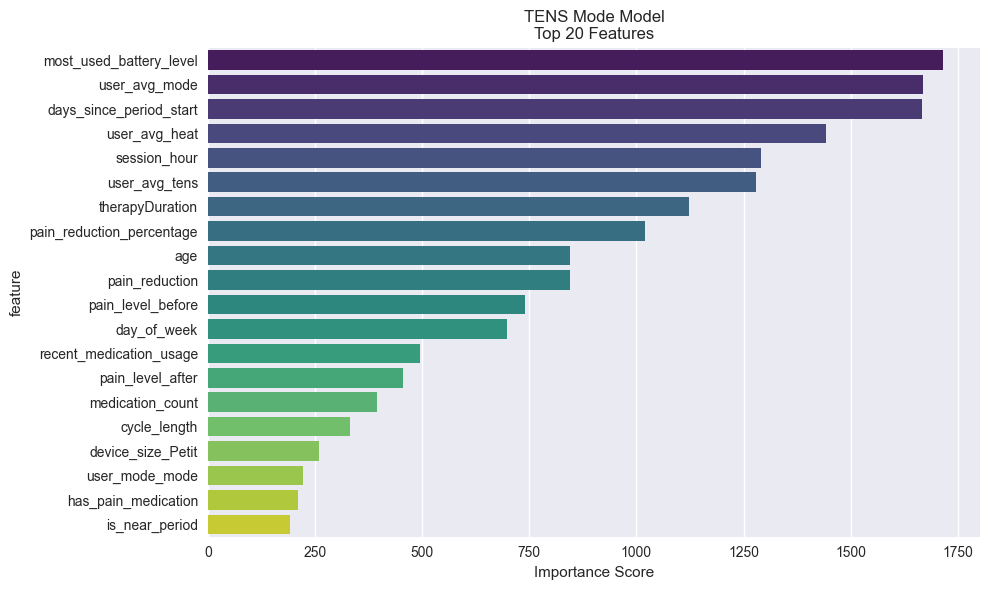

                      feature  importance
25    most_used_battery_level        1716
27              user_avg_mode        1669
3     days_since_period_start        1667
26              user_avg_heat        1443
16               session_hour        1291
28              user_avg_tens        1280
18            therapyDuration        1123
23  pain_reduction_percentage        1021
12                        age         845
22             pain_reduction         844

🎯 TENS Level Model (Stage 2) - Top Features:


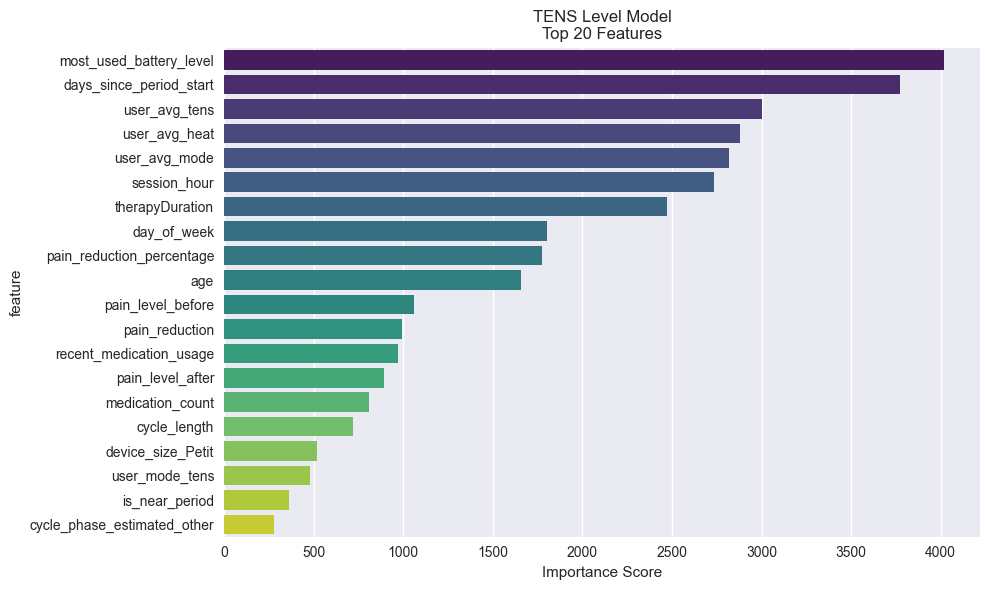

                      feature  importance
25    most_used_battery_level        4018
3     days_since_period_start        3770
28              user_avg_tens        3003
26              user_avg_heat        2878
27              user_avg_mode        2816
16               session_hour        2737
18            therapyDuration        2471
17                day_of_week        1803
23  pain_reduction_percentage        1777
12                        age        1658


In [ ]:
# Extract and visualize feature importance
print("🔍 Analyzing feature importance...")

def plot_feature_importance(model, feature_names, title, top_n=20):
    """Plot top N most important features"""
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title(f'{title}\nTop {top_n} Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Heat Level Feature Importance
print("\n🔥 Heat Level Model - Top Features:")
heat_importance = plot_feature_importance(heat_model, feature_cols, 'Heat Level Model')
print(heat_importance.head(10))

# TENS Mode Feature Importance
print("\n⚡ TENS Mode Model - Top Features:")
mode_importance = plot_feature_importance(mode_model, feature_cols, 'TENS Mode Model')
print(mode_importance.head(10))

# TENS Level Feature Importance
print("\n🎯 TENS Level Model (Stage 2) - Top Features:")
tens_importance = plot_feature_importance(tens_model, feature_cols, 'TENS Level Model')
print(tens_importance.head(10))

## 🔍 9. SHAP Analysis (Model Interpretability)

Using SHAP (SHapley Additive exPlanations) to understand:
- Which features drive predictions for each class
- Feature interactions
- Individual prediction explanations


In [ ]:
# Install SHAP if not already installed
try:
    import shap
    print("✅ SHAP already installed")
except ImportError:
    print("📦 Installing SHAP...")
    import sys
    !{sys.executable} -m pip install shap -q
    import shap
    print("✅ SHAP installed successfully")

# Create SHAP explainer for Heat Level Model
print("\n🔍 Computing SHAP values for Heat Level Model...")
print("   (This may take a few minutes...)")

# Use a sample of test data for faster computation
sample_size = min(100, len(X_test_full))
X_test_sample = X_test_full.sample(n=sample_size, random_state=42)

# Create explainer
explainer_heat = shap.TreeExplainer(heat_model)
shap_values_heat = explainer_heat.shap_values(X_test_sample)

print("✅ SHAP values computed!")

# Summary plot (shows top features for all classes)
print("\n📊 Generating SHAP summary plot for Heat Level Model...")
shap.summary_plot(shap_values_heat, X_test_sample, plot_type="bar", class_names=['Heat 0', 'Heat 1', 'Heat 2', 'Heat 3'], show=False)
plt.tight_layout()
plt.show()

# Detailed summary plot for class 2 (Heat 2)
print("\n📊 Detailed SHAP summary for Heat Level 2...")
shap.summary_plot(shap_values_heat[2], X_test_sample, show=False)
plt.tight_layout()
plt.show()


## 📊 10. Error Analysis & Model Diagnostics

### Objectives:
- Identify which predictions fail most often
- Understand patterns in misclassifications
- Find areas for model improvement


In [ ]:
# Error Analysis - Detailed breakdown of misclassifications
print("\n" + "="*80)
print("🔍 DETAILED ERROR ANALYSIS")
print("="*80)

# Create a test dataframe with predictions
test_analysis = test_df.copy()
test_analysis['pred_heat'] = y_pred_heat
test_analysis['pred_mode'] = y_pred_mode
test_analysis['pred_tens'] = y_pred_tens_hierarchical

# Heat Level Errors
print("\n🔥 HEAT LEVEL - Most Common Misclassifications:")
test_analysis['heat_error'] = (test_analysis['y_heat'] != test_analysis['pred_heat'])
heat_errors = test_analysis[test_analysis['heat_error']]
heat_confusion = test_analysis.groupby(['y_heat', 'pred_heat']).size().sort_values(ascending=False)
print(heat_confusion.head(10))

# Analyze what features correlate with heat errors
if len(heat_errors) > 0:
    print(f"\n   Heat error rate: {len(heat_errors)/len(test_analysis)*100:.1f}%")
    print(f"   Errors by pain level:")
    print(heat_errors.groupby('input_pain_level').size().sort_values(ascending=False).head(5))

# TENS Mode Errors
print("\n⚡ TENS MODE - Most Common Misclassifications:")
test_analysis['mode_error'] = (test_analysis['y_mode'] != test_analysis['pred_mode'])
mode_errors = test_analysis[test_analysis['mode_error']]
mode_confusion = test_analysis.groupby(['y_mode', 'pred_mode']).size().sort_values(ascending=False)
print(mode_confusion.head(10))

if len(mode_errors) > 0:
    print(f"\n   Mode error rate: {len(mode_errors)/len(test_analysis)*100:.1f}%")
    print(f"   Errors by user experience:")
    print(mode_errors['user_experience_level'].value_counts().head(5))

# TENS Level Errors
print("\n🎯 TENS LEVEL - Most Common Misclassifications:")
test_analysis['tens_error'] = (test_analysis['y_tens'] != test_analysis['pred_tens'])
tens_errors = test_analysis[test_analysis['tens_error']]
tens_confusion = test_analysis.groupby(['y_tens', 'pred_tens']).size().sort_values(ascending=False)
print(tens_confusion.head(15))

if len(tens_errors) > 0:
    print(f"\n   TENS error rate: {len(tens_errors)/len(test_analysis)*100:.1f}%")
    print(f"   Errors by predicted mode:")
    print(tens_errors.groupby('pred_mode').size())
    
# Overall error patterns
print("\n📊 Combined Error Patterns:")
all_correct = (~test_analysis['heat_error']) & (~test_analysis['mode_error']) & (~test_analysis['tens_error'])
print(f"   All 3 predictions correct: {all_correct.sum()} ({all_correct.sum()/len(test_analysis)*100:.1f}%)")
print(f"   At least 1 error: {(~all_correct).sum()} ({(~all_correct).sum()/len(test_analysis)*100:.1f}%)")

print("\n" + "="*80)



🎯 HIERARCHICAL CLASSIFICATION APPROACH - FINAL SUMMARY


                    Model  Classes  Accuracy  F1 Score  Training Samples
     Heat Level (Stage 1)        4  0.552760  0.423445             24095
      TENS Mode (Stage 1)        4  0.633929  0.579090             24095
TENS Level (Hierarchical)       11  0.300325  0.234871             24095


✅ Approach 2 (Hierarchical Classification) Complete!

📌 Key Advantages:
   • Enforces physical constraints (Mode → Level dependency)
   • Higher accuracy for TENS Level by training on relevant data only
   • Interpretable two-stage prediction process
   • Reduces class imbalance in Stage 2 model



## 💾 11. Summary & Model Export

### Key Improvements Applied:
1. ✅ **Class Balancing**: Used `class_weight='balanced'` to handle imbalanced classes
2. ✅ **Better Hyperparameters**: Increased estimators, adjusted learning rate, added regularization
3. ✅ **Early Stopping**: Prevents overfitting and saves computation
4. ✅ **Cross-Validation**: Validates model generalization
5. ✅ **Confidence-Based Prediction**: Only uses Stage 2 when confident about Mode
6. ✅ **Improved Features**: Added interaction features, rolling averages, temporal patterns
7. ✅ **Fixed Data Leakage**: User history uses only past data
8. ✅ **SHAP Analysis**: Model interpretability
9. ✅ **Error Analysis**: Detailed breakdown of failures


In [ ]:
# Save models
import joblib
import os

# Create models directory
models_dir = 'models/hierarchical_approach'
os.makedirs(models_dir, exist_ok=True)

# Save models
joblib.dump(heat_model, f'{models_dir}/heat_level_model.pkl')
joblib.dump(mode_model, f'{models_dir}/tens_mode_model.pkl')
joblib.dump(tens_model, f'{models_dir}/tens_level_model.pkl')

# Save feature names
joblib.dump(feature_cols, f'{models_dir}/feature_columns.pkl')

print(f"✅ Models saved to {models_dir}/")
print("   - heat_level_model.pkl")
print("   - tens_mode_model.pkl")
print("   - tens_level_model.pkl")
print("   - feature_columns.pkl")

✅ Models saved to models/hierarchical_approach/
   - heat_level_model.pkl
   - tens_mode_model.pkl
   - tens_level_model.pkl
   - feature_columns.pkl
